# Constraining Cosmology

Suppose we now have three observed data for Redshift and Luminosity Distance, $z_i \pm \delta z_i$, $d_i \pm \delta d_i$, how well can we constrain the Cosmological parameters $H_0$, $\Omega_{\Lambda}$, $\Omega_M$, $\omega$?
$$
d_l(z) = (1+z) d_c(z) = (1+z)\frac{c}{H_0} \int_0 d z^{'} \frac{1}{\sqrt{\Omega_{\Lambda}(1+z^{'})^{3(1+\omega)}+\Omega_M  (1+z^{'})^{3}}},
$$
With the observed data, in principle we can determine the range of $H_0$, $\Omega_{\Lambda}$ and $\Omega_M$ from the equation above.

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import corner
import scipy.integrate as integrate
from scipy.stats import norm
import h5py
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import seaborn as sns
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

/Users/hyraland/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/hyraland/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


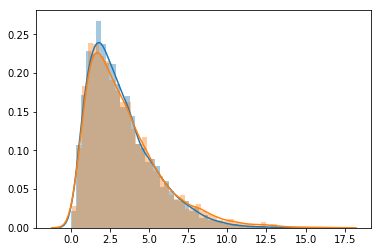

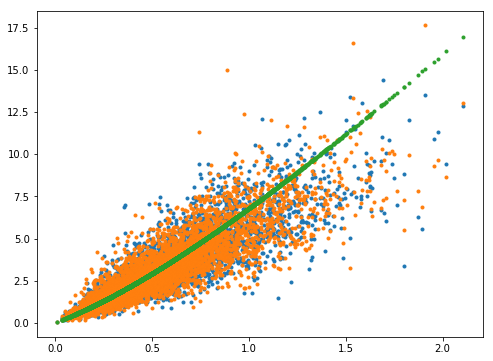

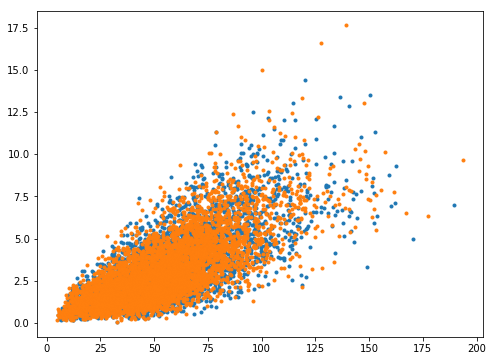

In [2]:
filename = '/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/observations.h5'
data = h5py.File(filename, 'r')

# keys: etaobs,m1s,m2s,mcobs,posterior,rhoobs,sigma_eta,sigma_mc,sigma_rho,sigma_t,thetaobs,thetas
z = data['zs'].value  # 4558
m1 = data['m1s'].value
m2 = data['m2s'].value
dl = data['posteriors/dl'].value # 4558*4000
m1det = data['posteriors/m1det'].value
m2det = data['posteriors/m2det'].value

dl_z = Planck15.luminosity_distance(z).to(u.Gpc).value

sns.distplot(dl[:,0])
sns.distplot(dl_z)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z, dl[:, 0], '.')
plt.plot(z, dl[:,3999], '.')
plt.plot(z, dl_z, '.')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m1det[:,0], dl[:,0],'.')
plt.plot(m1det[:,3999], dl[:,3999],'.')
plt.show()
    
data.close()

In [3]:
# nbin = 9
# dlrange = np.linspace(min(dl[:,0]), max(dl[:,0]), nbin+3)

# m90 = np.linspace(0, 0, nbin)
# m90sq = np.linspace(0, 0, nbin)
# m90_std = np.linspace(0, 0, nbin)
# m90_dl = np.linspace(0, 0, nbin)
# m90_dl_sq = np.linspace(0, 0, nbin)
# m90_dl_std = np.linspace(0, 0, nbin)

# for j in range(nbin):
# #     m90_dl[j] = 0.5*(dlrange[j]+dlrange[j+1])
# #     m90_dl_std[j] = 0.5*(dlrange[j+1]-dlrange[j])
# #     print(m90_dl[j])
#     for k in range(4000):
#         m90_temp = []
#         m90_back = []
#         dl90_temp = []
#         for i in range(len(dl[:,k])):
#             dl_t = dl[i,k]  
#             if dl_t > dlrange[j] and dl_t < dlrange[j+1]:
#                 m90_temp.append(m1det[i,k])
#                 m90_back.append(m1det[i,k])
#                 dl90_temp.append(dl_t)
#         ind90 = int(len(m90_temp)*0.9)
#         if len(m90_temp)*0.9 < 1:
#             ind90 = 0
#         m90t = (np.sort(np.asarray(m90_temp))[ind90])
#         dlind = np.where(m90_back == m90t)
#         dl90t = np.asarray(dl90_temp)[dlind]
#         m90_dl[j] += dl90t
#         m90_dl_sq[j] += dl90t**2
#         m90[j] += m90t
#         m90sq[j] += m90t**2
#     print(m90_dl[j], m90sq[j])
# m90 = m90/4000
# m90_dl = m90_dl/4000
# for i in range(nbin):
#     m90_std[i] = np.sqrt(m90sq[i]/4000-m90[i]**2)
#     m90_dl_std[i] = np.sqrt(m90_dl_sq[i]/4000-m90_dl[i]**2)

# plt.errorbar(m90_dl, m90, xerr = m90_dl_std, yerr = m90_std)
# plt.show()


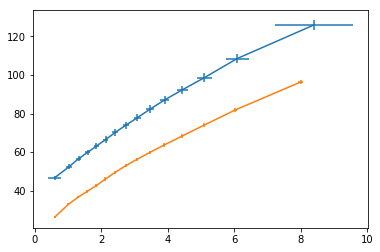

In [9]:
nbin = 15
tots = 1000

m90 = np.linspace(0, 0, nbin)
m50 = np.linspace(0, 0, nbin)
m90_dl = np.linspace(0, 0, nbin)
m50_dl = np.linspace(0, 0, nbin)

m902 = np.linspace(0, 0, nbin)
m502 = np.linspace(0, 0, nbin)
m90_dl2 = np.linspace(0, 0, nbin)
m50_dl2 = np.linspace(0, 0, nbin)

m90_std = np.linspace(0, 0, nbin)
m90_dl_std = np.linspace(0, 0, nbin)
m50_std = np.linspace(0, 0, nbin)
m50_dl_std = np.linspace(0, 0, nbin)

for k in range(tots):

    nsample = len(m1det[:,k])+0.0
    nperbin = int(nsample/(nbin))
    count = 0
    pairdlm = sorted(zip(dl[:,k], m1det[:,k]))
    m1sort = [x1 for _,x1 in pairdlm]
    dlsort = [x2 for x2,_ in pairdlm]

    for j in range(nbin):

        m_temp = []
        m90_back = []
        dl_temp = []
        for i in range(nperbin): 
            m_temp.append(m1sort[i+count*nperbin])
            m90_back.append(m1sort[i+count*nperbin])
            dl_temp.append(dlsort[i+count*nperbin])
        ind90 = int(len(m_temp)*0.9)
        #print(j, ind90, len(m90_temp))
        if len(m_temp)*0.9 < 1:
            ind90 = 0
        m90t = (np.sort(np.asarray(m_temp))[ind90])
        m90[j] += m90t
        m902[j] += m90t**2
        dlind = np.where(m90_back == m90t)
        m90_dl[j] += np.asarray(dl_temp)[dlind]
        m90_dl2[j] += np.asarray(dl_temp)[dlind]**2
        m50[j] += np.mean(m_temp)
        m502[j] += np.mean(m_temp)**2
        m50_dl[j] += np.mean(dl_temp)
        m50_dl2[j] += np.mean(dl_temp)**2
        count += 1

m50 = m50/tots
m90 = m90/tots
m50_dl = m50_dl/tots
m90_dl = m90_dl/tots
m50_std = np.sqrt(m502/tots-(m50)**2)
m90_std = np.sqrt(m902/tots-(m90)**2)
m50_dl_std = np.sqrt(m50_dl2/tots-(m50_dl)**2)
m90_dl_std = np.sqrt(m90_dl2/tots-(m90_dl)**2) 

    
plt.errorbar(m90_dl, m90, xerr = m90_dl_std, yerr = m90_std)
plt.errorbar(m50_dl, m50, xerr = m50_dl_std, yerr = m50_std)

plt.show()

In [4]:
m90info = np.stack((m90_dl,m90,m90_std,m90_dl_std))
print(m90info)
#np.savetxt('m90.txt',m90info)

[[  1.00164246   2.11746692   3.35396649   4.63051378   5.93077973
    7.22108699   8.50080529   9.78322835  11.07880029]
 [ 51.59173769  65.43968463  80.47792177  93.97340359 106.86613662
  119.30332453 128.70753006 135.76975266 141.63055738]
 [  0.71212574   0.66389673   1.04677091   1.47659056   2.28556231
    3.43392115   5.11882674   7.84605683  13.34406833]
 [  0.25995023   0.35810147   0.3763383    0.37516566   0.38055625
    0.37280761   0.3750567    0.36951842   0.36919726]]


In [5]:
mvsdl = interp1d(m90_dl, m90)
zdl = np.linspace(0,0,nbin)
zdl_std = np.linspace(0,0,nbin)
for i in range(nbin-1):
    zdl[i+1] = m90[i+1]/m90[0]-1
    zdl_std[i+1] = zdl[i+1] * np.sqrt((m90_std[0]/m90[0])**2+(m90_std[i+1]/m90[i+1])**2)

In [11]:
# testing cosmology package
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
cosmo = FlatLambdaCDM(H0=68 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.29)

-0.03545258821707763
0.0031174705339277716
0.04225029850454678
0.07616758703679631
0.11252162197553145
0.15843044091070332
0.20958771290159556
0.24962697197070757
0.3220544795816592
0.39216623920895705
0.4633792249067053
0.5228093433081611
0.6166932507383586
0.7681460874590901
0.8970632706713739


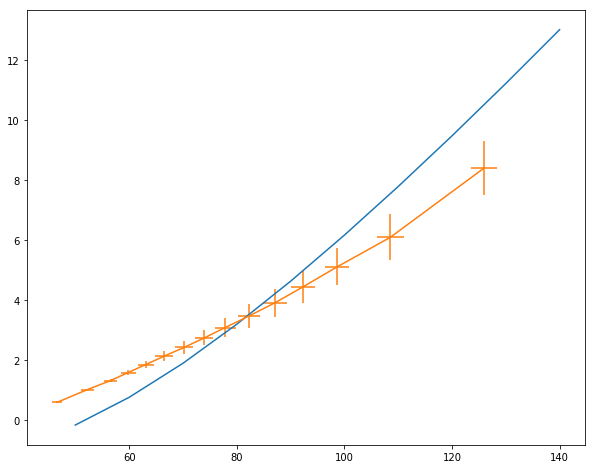

In [14]:
#z = np.asarray(zdl)
dlf = np.asarray(m90_dl)
#zerr = np.asarray(zdl_std)
dlerr = np.asarray(m90_dl_std)

# def dlofz(z, h0, omegam, om):
#     c =  3*10**5
#     omegal = 1- omegam
#     tau = lambda x, omegalf, omegamf, omf : 1/(np.sqrt(omegalf * (1+x)**(3*(1+omf)) + omegamf * (1+x)**3))
#     dl = []
#     for i in z:
#         inte, err = integrate.quad(tau, 0, i, args=(omegal, omegam, om, ))
#         dl.append((1+i) * c/h0/1000 * inte)
#         #dl.append((1+i) * c * inte)
#     return np.array(dl)

def dlofm(m90, m90_0, h0, omegam, om):
    c =  3*10**5
    z = m90/m90_0-1
    omegal = 1- omegam
    tau = lambda x, omegalf, omegamf, omf : 1/(np.sqrt(omegalf * (1+x)**(3*(1+omf)) + omegamf * (1+x)**3))
    dl = []
    for i in z:
        inte, err = integrate.quad(tau, 0, i, args=(omegal, omegam, om, ))
        dl.append((1+i) * c/h0/1000 * inte)
        #dl.append((1+i) * c * inte)
    return np.array(dl)

def dlofmstd(m90, m90_std, m90_0, h0, omegam, om):
    c =  3*10**5
    z = m90/m90_0-1
    omegal = 1- omegam
    dtau = 1/(np.sqrt(omegal * (1+m90)**(3*(1+om)) + omegam * (1+m90)**3))
    dl = []
    
    tau = lambda x, omegalf, omegamf, omf : 1/(np.sqrt(omegalf * (1+x)**(3*(1+omf)) + omegamf * (1+x)**3))
    dl1 = []
    
    for i in z:
        inte, err = integrate.quad(tau, 0, i, args=(omegal, omegam, om, ))
        dl1.append(c/h0/1000 * inte)
    for i in range(len(z)):
        sigtemp = (1+z[i]) * c/h0/1000 * dtau[i]*m90_std[i]/m90_0 + 1* c/h0/1000 *dl1[i]*m90_std[i]/m90_0
        print(sigtemp)
        dl.append(abs(sigtemp))
        #dl.append((1+i) * c * inte)
    return np.array(dl)

mtest = np.linspace(50,140,10)
dltest = np.linspace(0,1,10)
h0test = Planck15.H0.value
omegamtest = Planck15.Om0
omtest = -1.0
m90_0_test = 52.0
dltest = dlofm(mtest, m90_0_test, h0test, omegamtest, omtest)

m90_dl_std = dlofmstd(m90, m90_std, m90_0_test, h0test, omegamtest, omtest)

dlcosmo = cosmo.luminosity_distance(mtest/m90_0_test).to(u.Gpc).value

plt.figure(figsize=(10,8))
plt.plot(mtest, dltest)
plt.errorbar(m90, dlf, xerr=m90_std, yerr=dlerr)
#plt.yscale('log')
plt.show()
    
def log_prior_m90(m90_0):
    if ((m90_0 < 40) or (m90_0 > 70)):
        return np.NINF
    else:
        return np.log(norm.pdf(m90_0, 60, 10))
    
def log_prior_h0(h0):
    if ((h0 < 35) or (h0 > 140)):
        return np.NINF
    else:
        return np.log(norm.pdf(h0, 70, 15))

def log_prior_omega(omegam):
    if ((omegam < 0.0) or (omegam >= 1)):
        return np.NINF
    else:
        return np.log(norm.pdf(omegam, 0.3, 0.15))

def log_prior_om(om):
    if ((om > -0.0) or (om < -2.0)):
        return np.NINF
    else:
        return np.log(norm.pdf(om, -1, 0.5))

def log_likelihood(dl,m,sigmadl,sigmam, m90_0, h0, omegam, om):
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigmadl**2 + sigmam**2)))  #not sure yet
    chi2 = (dl - dlofm(m,m90_0,h0,omegam,om))**2 / (sigmadl**2 + sigmam**2)
    #print('dlofz', dlofz(z,h0,omegal,omegam,om))
    term2 = -0.5*np.sum(chi2)
    return term1+term2

def log_posterior(params, m, dl, sigmam, sigmadl):
    m90_0, h0, omegam, om=params
    lnP = log_likelihood(dl,m,sigmadl,sigmam, m90_0, h0, omegam, om) + log_prior_m90(m90_0) + log_prior_h0(h0) + log_prior_omega(omegam) + log_prior_om(om)
    # safeguard against NaNs: 
    # print(h0, omegal, omegam, om)
    #print (lnP, log_prior_h0(h0), log_prior_omega(omegal, omegam), log_prior_om(om))
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP

In [15]:
m90info = np.stack((m90_dl,m90,m90_std,m90_dl_std))

print(m90info)
#np.savetxt('m90.txt',m90info)

[[5.91393413e-01 1.01875617e+00 1.31506043e+00 1.58342462e+00
  1.85083245e+00 2.12904600e+00 2.42025392e+00 2.73654875e+00
  3.08319799e+00 3.46641382e+00 3.90762857e+00 4.43497496e+00
  5.10570387e+00 6.08956098e+00 8.40509910e+00]
 [4.66257922e+01 5.22840185e+01 5.65438771e+01 5.98037208e+01
  6.30997001e+01 6.64908734e+01 7.02006663e+01 7.39329378e+01
  7.78340853e+01 8.22489296e+01 8.70845287e+01 9.22701696e+01
  9.86422797e+01 1.08527454e+02 1.26001971e+02]
 [8.98228159e-01 1.27008107e+00 1.29337842e+00 1.38566167e+00
  1.46544830e+00 1.60919915e+00 1.72837870e+00 1.74225344e+00
  1.94814952e+00 2.07404182e+00 2.16778226e+00 2.19005540e+00
  2.30615854e+00 2.49399887e+00 2.42571968e+00]
 [3.54525882e-02 3.11747053e-03 4.22502985e-02 7.61675870e-02
  1.12521622e-01 1.58430441e-01 2.09587713e-01 2.49626972e-01
  3.22054480e-01 3.92166239e-01 4.63379225e-01 5.22809343e-01
  6.16693251e-01 7.68146087e-01 8.97063271e-01]]


In [16]:
import emcee

In [17]:
ndim = 4  # number of parameters in the model

nwalkers = 50  # number of MCMC walkers
nsteps = 2000  # number of MCMC steps to take


In [18]:
# set starting guesses as random numbers (thus, each walker starts from a different position):
np.random.seed()
# np.random.random generates a list of random variables in the range of 0 to 1 - easy to transform
# since this is fake data, we know the truth: a=25, b=0.5
# guess for m90_0:  50...60
guess_m90_0=40*np.random.random(nwalkers)+50
# guess for h0:  65...70
guess_h0=20*np.random.random(nwalkers)+65
# guess for omegal:  0...1
guess_omegam=0.97-np.random.random(nwalkers)/2
# guess for om:  0...-2
guess_om= - np.random.random(nwalkers)/2
# need to pass as one array:
starting_guesses = np.column_stack((guess_m90_0,guess_h0,guess_omegam, guess_om))

print (starting_guesses)

[[ 6.30008912e+01  7.19147917e+01  8.22003921e-01 -1.34919065e-01]
 [ 8.15628266e+01  7.98190401e+01  8.37592366e-01 -4.93998141e-01]
 [ 7.73080654e+01  6.68083828e+01  6.51473067e-01 -4.65372613e-02]
 [ 5.16317354e+01  8.35900275e+01  9.63109386e-01 -2.25135255e-02]
 [ 5.90245090e+01  6.53494859e+01  6.63384726e-01 -1.34390943e-01]
 [ 7.26265033e+01  8.24463915e+01  8.26255234e-01 -1.62071503e-01]
 [ 8.26503801e+01  7.67412012e+01  7.38773393e-01 -3.57541224e-03]
 [ 5.29452124e+01  7.79098151e+01  7.33428603e-01 -3.61446291e-01]
 [ 8.13075137e+01  8.05043989e+01  7.27398008e-01 -3.84542404e-01]
 [ 5.68717682e+01  6.99272219e+01  8.64490225e-01 -1.50910583e-01]
 [ 8.82570291e+01  6.61348501e+01  5.47113706e-01 -2.64370220e-01]
 [ 7.64130548e+01  8.26873846e+01  5.11392540e-01 -3.95738663e-01]
 [ 8.44418361e+01  8.38588540e+01  8.15857194e-01 -4.90558352e-01]
 [ 6.73099596e+01  7.04976989e+01  9.39958299e-01 -2.17295031e-01]
 [ 6.89483845e+01  8.44454364e+01  4.82448147e-01 -1.94407951e

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[m90, dlf, m90_std, dlerr])
pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps)

/Users/hyraland/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/hyraland/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/hyraland/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [20]:
print(sampler.chain.shape)

(50, 2000, 4)


/Users/hyraland/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


[56.66906146 67.49474479  0.12919753 -1.51684598]


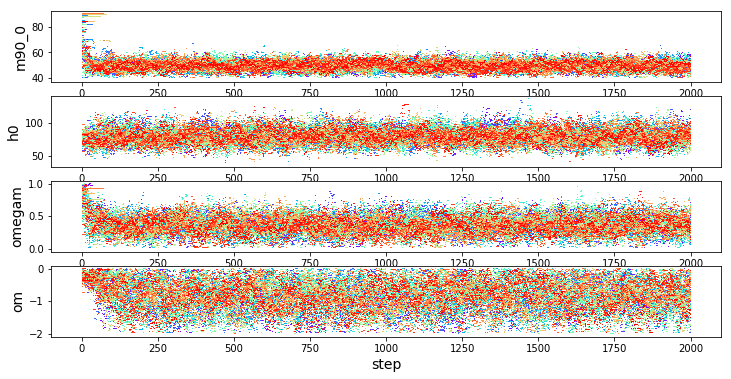

In [21]:
color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))

# set up a plot with two windows, one for each parameter:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.ylabel('m90_0', fontsize=14);
plt.subplot(412)
plt.ylabel('h0', fontsize=14);
plt.subplot(413)
plt.ylabel('omegam', fontsize=14);
plt.subplot(414)
plt.ylabel('om', fontsize=14);
plt.xlabel('step', fontsize=14);

# loop over the walkers
for j in range(nwalkers):
    # each walker gets assigned a color
    c=next(color)
    plt.subplot(411)#, xlim=(500, 1750), ylim= (0, 2))
    # a walker is identified by the index in the first array dimension
    # the ":" for the second dimension takes all its elements in this dimension
    # the third index specifies which parameter to read out
    plt.plot(sampler.chain[j,:,0], ',', color=c)
    plt.subplot(412)#, xlim=(500, 1750))
    plt.plot(sampler.chain[j,:,1], ',', color=c)
    plt.subplot(413)#, xlim=(500, 1750))
    plt.plot(sampler.chain[j,:,2], ',', color=c)
    plt.subplot(414)#, xlim=(500, 1750))
    plt.plot(sampler.chain[j,:,3], ',', color=c)
    
print(sampler.chain[j,-1,:])

In [22]:
nburn=500

In [23]:
post = np.concatenate(sampler.chain[:, nburn:, :])
print(post[0,:].std())

31.96852953724302


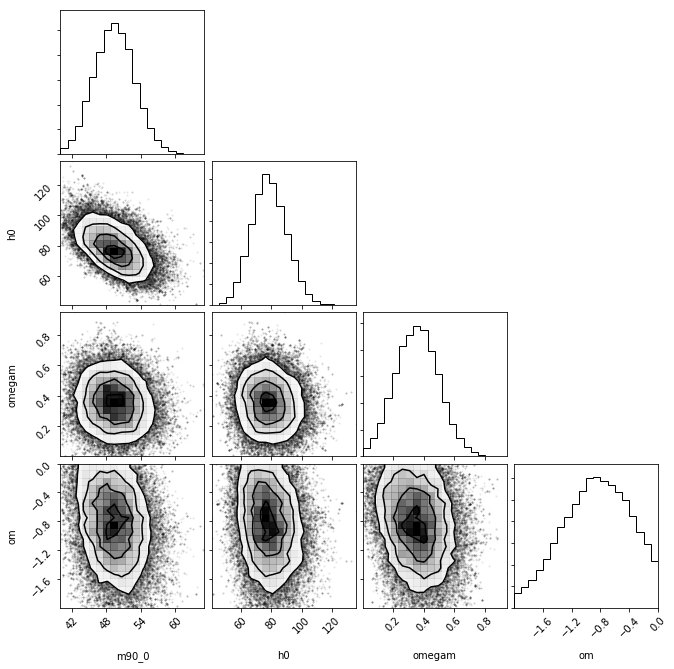

In [24]:
corner.corner(post,labels=["m90_0","h0", "omegam", "om"]);

In [28]:
print ("m90_0")
print (np.percentile(post[:,0],16))
print (np.percentile(post[:,0],50))
print (np.percentile(post[:,0],84))

print ("h0")
print (np.percentile(post[:,1],16))
print (np.percentile(post[:,1],50))
print (np.percentile(post[:,1],84))

print ("omegam")
print (np.percentile(post[:,2],16))
print (np.percentile(post[:,2],50))
print (np.percentile(post[:,2],84))

print ("om")
print (np.percentile(post[:,3],16))
print (np.percentile(post[:,3],50))
print (np.percentile(post[:,3],84))


m90_0
45.85020634525466
49.37246626933493
52.824367805864966
h0
67.0465820405858
78.18001107098952
90.24394679036818
omegam
0.21461328050311856
0.3548288644049635
0.49720422633144307
om
-1.344169027344885
-0.8447072293501496
-0.3811352347743975


-0.010738650245817556 0.27981875094253206
0.8686756071656667 0.3611746929317497
1.9149437468170636 0.45001841873984255
3.088997767791232 0.5523172001379085
4.362473835809648 0.6738306996078053
5.715336462340049 0.8164558535814894
7.1332784970656595 0.9795382137089811
8.605812769288018 1.1614289058545997
10.12502403009892 1.3603105232029196
11.684773086073147 1.5745037381460418


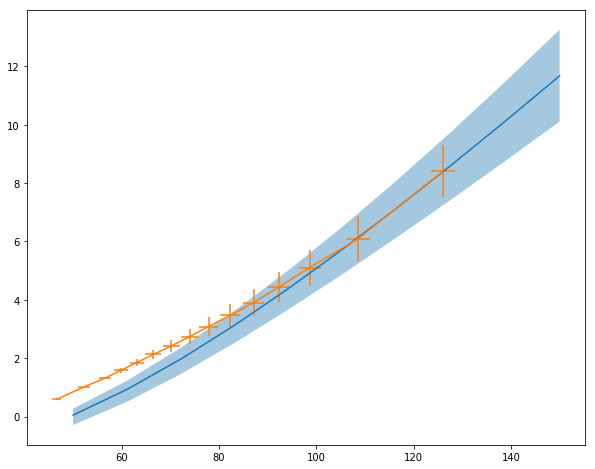

In [31]:
mfit = np.linspace(50,150,10)
dlfit = np.linspace(0,1,10)
h0fit = np.percentile(post[:,1],50)
omegamfit = np.percentile(post[:,2],50)
omfit = np.percentile(post[:,3],50)
m90_0_fit = np.percentile(post[:,0],50)
dlfit = dlofm(mtest, m90_0_fit, h0fit, omegamfit, omfit)



mfit1 = np.linspace(56,150,10)
dlfit1 = np.linspace(0,1,10)
h0fit1 = np.percentile(post[:,1],16)
omegamfit1 = np.percentile(post[:,2],16)
omfit1 = np.percentile(post[:,3],16)
m90_0_fit1 = np.percentile(post[:,0],16)
dlfit1 = dlofm(mtest, m90_0_fit1, h0fit1, omegamfit1, omfit1)

mfit2 = np.linspace(56,150,10)
dlfit2 = np.linspace(0,1,10)
h0fit2 = np.percentile(post[:,1],84)
omegamfit2 = np.percentile(post[:,2],84)
omfit2 = np.percentile(post[:,3],84)
m90_0_fit2 = np.percentile(post[:,0],84)
dlfit2 = dlofm(mtest, m90_0_fit2, h0fit2, omegamfit2, omfit2)

dlcosmo = cosmo.luminosity_distance(mtest/m90_0_test).to(u.Gpc).value

plt.figure(figsize=(10,8))
plt.plot(mfit, dlfit, label='Fit')
#plt.fill_between(mfit, dlfit1, dlfit2, alpha = 0.4)
#plt.plot(mtest, dltest, label='Initial')
dlfrange = np.linspace(0,0,2000)
dlmean = np.linspace(0,0,10)
dlstd = np.linspace(0,0,10)
for i in range(10):
    for j in range(2000):
        dlfrange[j] = dlofm(mtest, post[j,0], post[j,1], post[j,2], post[j,3])[i]
    print(np.mean(dlfrange),np.std(dlfrange))
    dlmean[i] = np.mean(dlfrange)
    dlstd[i] = np.std(dlfrange)
plt.fill_between(mfit, dlmean-dlstd, dlmean+dlstd, alpha = 0.4)
#plt.plot(mfit, dlmean, label='mean')
plt.errorbar(m90, dlf, xerr=m90_std, yerr=dlerr)
#plt.yscale('log')
plt.show()
